In [1]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd



Mounted at /content/drive


In [3]:
#path yolunun oluşturulması
path="/content/drive/MyDrive/Data/"

#train.csv okunması

data=pd.read_csv(path + 'trainLabels.csv')


data.info() #Sutunların tipine bakma.




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1427 non-null   object
 1   level   1427 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


Verilerimizin dağılımına bakma

In [4]:
import plotly.express as px

def pieChart(data,degisken):

    """data=data, sutun=göstermek istediğiniz "sutun""strıng olarak giriniz"  """
    data=data
    fig = px.pie(data, values=degisken, names=degisken)
    fig.show()

data['level'].value_counts() 

#Görselleştirme
pieChart(data,"level")

In [5]:
data['level'].value_counts() 

0    1016
2     230
1     113
4      36
3      32
Name: level, dtype: int64

In [6]:
path1="/content/drive/MyDrive/AI_Healthy_Issues/"


import os #os=operating system (işletim sistemi)

#dosyada bulunan görüntüleri list şeklinde kullanmak için listdir() fonk. kullanacağız.

files=os.listdir(path1 + "dataset") #dosya içinde dosya yapmışım benim hatam :/

len(files) #kaç tane dosya olduğunu öğrenme



1427

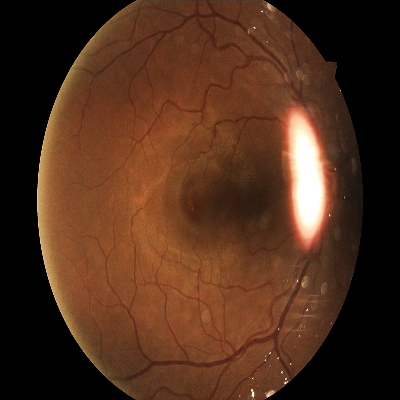

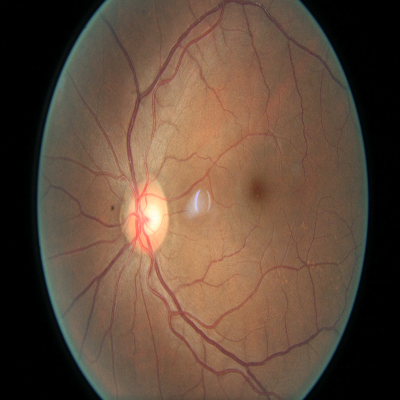

In [7]:
#boş bir list oluşturalım ve tüm resimleri bunun içine dolduralım for loop ile.

from google.colab.patches import cv2_imshow
import cv2
img_list1= [] 

for i in files[0:10]: #ilk on görüntüyü alıcaz.
    image=cv2.imread(path1 + "dataset/"+i) #dosyaların bulunduğu konumu girmemizi istiyoruz ardından okunan her görüntüyü temsil etmesi için "i" ekliyoruz.
    image=cv2.resize(image,(400,400)) #boyutlarını ayarlama.
    #boş listeye ekleme
    img_list1.append(image)

len(img_list1)

#ilk on görüntüden bazılarını gösterme
cv2_imshow(img_list1[0])
cv2.waitKey()

cv2_imshow(img_list1[5])
cv2.waitKey()

cv2.destroyAllWindows()



#Görüldüğü üzere tüm görüntülerin boyutları ve netlikleri birbirinden farklı ,bundan modelimizin daha iyi analizi için bazı işlemler uygulayacağız.

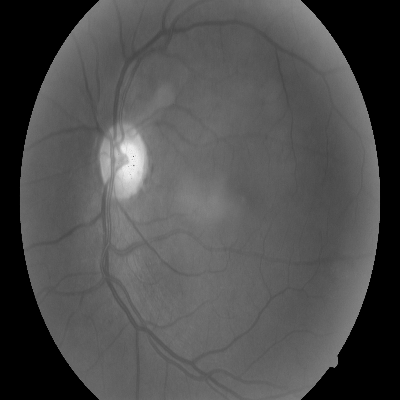

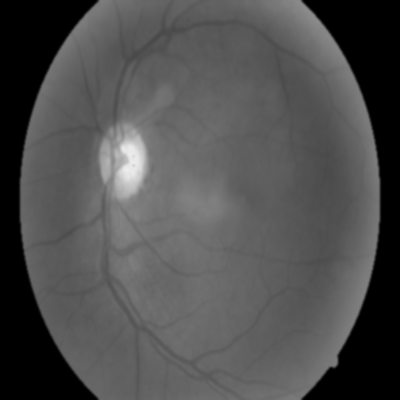

In [8]:
#Resimlerimizie Gaussian Blur uygulayacağız.

#Öncesinde gray kanala çevirmemiz gerekiyor.

copy_img=img_list1[4].copy()
copy_img=cv2.cvtColor(copy_img,cv2.COLOR_BGR2GRAY)

cv2_imshow(copy_img)
cv2.waitKey()
cv2.destroyAllWindows()

copy_img.shape #gördüğünüz gibi tek kanala indirgedik Gray kanala çevirerek.

#Threshold'dan önce blur'lama işlemi uyguladık.
#Gaussian blur--> cv2.GaussianBlur(görüntü,çekirdek(kernel),sigmaX ve sigmaY ) #eğer sigmaX=0 olarak girerseniz sigmaX ve sigmaY değerlerini otomatik olarak kendi hesaplayacaktır.

blur=cv2.GaussianBlur(copy_img,(5,5),0) # you can change for best solution

cv2_imshow(blur)
cv2.waitKey()
cv2.destroyAllWindows()

#Threshold'lama işlemi
#threshold--> cv2.threshold(görüntü,eşik değeri, max. değer , threshold tipi)
thresh=cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]


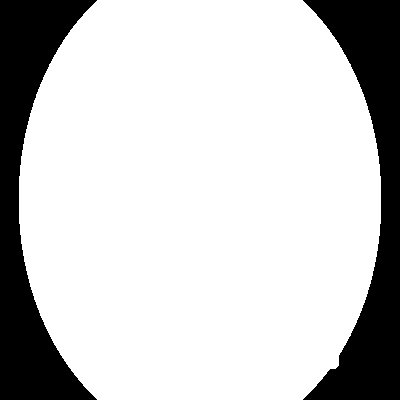

In [9]:
cv2_imshow(thresh)
cv2.waitKey()
cv2.destroyAllWindows()

Contour bulup görüntüyü KIRPMA

In [10]:
#Contour'un karşılığı,görüntüdeki sınırların belirlenmesidir.

contour=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] ##Retr_external sadece dış contourları çıkarmak istiyorsanız faydalı olabilir. Aykırı değerleri döndürürken, CHAIN_APPROX_SIMPLE ise sadece uçtaki 4 noktanın konumunu bize verir.

# print(contour) yazdığınızda uzun sıralı ikili x-y koordinatları ve ayrıca hierchical dediğimiz bir array list daha göreceksiniz hierchial şuan konumuz olmadığından geçiyoruz.[0] kullanmanın nedeni


#Şuan bir tuple şeklinde, ben array şeklinde olmasını ve shape'ini merak ediyorum 
#Bunun için bazı işlemler yapmam gerekiyor.


contour=contour[0] # bu şekilde tuple'dan kurtuldum.

print(contour.shape) #output ==(572, 1, 2) #572 tane ve 2'li koordinat bilgisine sahipim ama ortada 1 benim istemediğim bir boyut.
#bunun için de 
contour=contour[:,0,:] #bunun anlamı 572 hepsi , ve 2'lerin hepsi.


#Boyut kontrolü
contour.shape #1 boyut silinmiş oldu.

(372, 1, 2)


(372, 2)

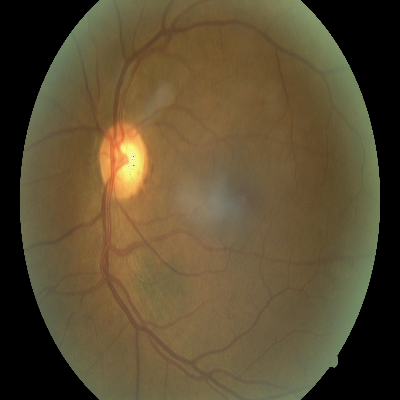

In [11]:
#Uç noktaların tespiti
contour[:,0].argmax()#x ekseninde maksimum değere sahip olan değerin, INDEX değerini döndürür


#contour[419] #en uç kısım x'de 398'miş.

contour[:,0].argmin()#x ekseninde minimum değere sahip olan değerin, INDEX değerini döndürür

#contour[141] # en düşük değer ise 2'miş

# print(f"x ekseninde max ve minumum değerlerimiz sırasıyla {contour[419][0] } , {contour[141][0]}'dir.")


#Bunları toplu bir şekilde hem x hem de y olacak şekilde ayarlayalım.

sol=tuple(contour[contour[:,0].argmin()])
sag=tuple(contour[contour[:,0].argmax()])
ust=tuple(contour[contour[:,1].argmin()])
alt=tuple(contour[contour[:,1].argmax()])


#x1,y1,x2,y2 şeklinde bir tuple oluşturalım.
x1=sol[0]
y1=ust[1]
x2=sag[0]
y2=alt[1]

x1,y1,x2,y2

# uç noktaları alıp kırpma işlemi yapacağız.Ancak asıl görüntümüze bir sorun olmaması için copy kullanacağız.
orig=img_list1[4].copy()

cv2_imshow(orig)
cv2.waitKey()
cv2.destroyAllWindows()

Kırpma işlemi

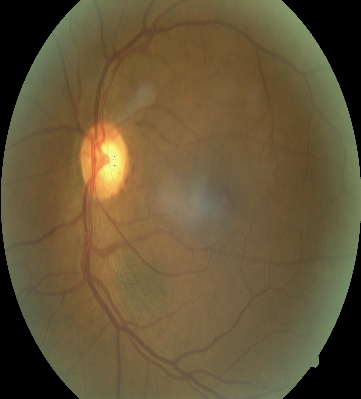

In [12]:


#Crop (kırpılmış) görüntü

crop_img=orig[y1:y2, x1 : x2]

cv2_imshow(crop_img)
cv2.waitKey()
cv2.destroyAllWindows()

crop_img=cv2.resize(crop_img,(400,400))

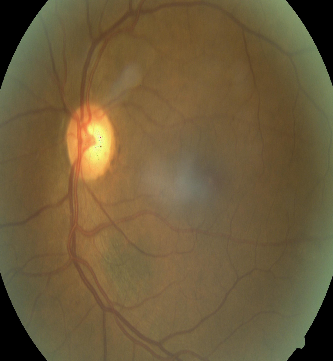

In [13]:
#Daha iyi bir kırpma işlemi ve gereksiz siyah alanlardan kurtulmak için, x ve y'nin standart sapmalarını alacağız.
x=int(x2-x1)*4//100
y=int(y2-y1)*5//100  #bu ifadeleri y1 ve x2 gibi ifadelere ekleyip çıkarıcam


############
crop_son=orig[y1+y:y2-y, x1+x : x2-x]

cv2_imshow(crop_son)
cv2.waitKey()
cv2.destroyAllWindows() #Gördüğünüz üzere siyah noktalardan biraz daha arınmış olduk.

crop_son=cv2.resize(crop_son,(400,400))

#Kaagle'dan veya başka veri setlerinden aldığınız eşit olmayan görüntüleri bu şekilde kırpmanız ve hepsini aynı boyuta getirmeniz modelin başarısında önemli bir etkiye sahip olacaktır.

CLAHE- Kontrast Limitli Adaptif Histogram Eşitleme

Histogram Eşitleme nedir? 
Histogram eşitleme,kontrastı iyileştirmek için kullanılan bir görüntü tekniğidir. Bu tekniğin uygulanmasındaki temel amaç, görüntüdeki nesnelerin farkedilmesi veya daha keskin hale getirilmesidir. 


------------------------------------------
Ancak şunu belirtmekte de fayda var, eğer şayet görüntümüzün pixel değer dağılımı; düzgün dağılmamışsa,belirli bir değer aralığında pik yapmışsa normal histogram eşitleme görüntüyü keskinleştirmekten çok daha da bozar.

------------------------------------------
Bu sorunun üstesinden gelmek için,görüntüyü küçük küçük parçalara ayırıp, ona göre histogram eşitlemesi yapan yöntemimiz olan Adaptif Histogram Eşitleme kullanacağız. Şayet bunu kontrast limitiyle(CLAHE) de yapmazsanız, görüntünün bazı yerlerin aşırıya kaçacağı için kumlanma(noise) meydana gelebilir.Bu durumda bizim istemediğimiz bir durumdur.

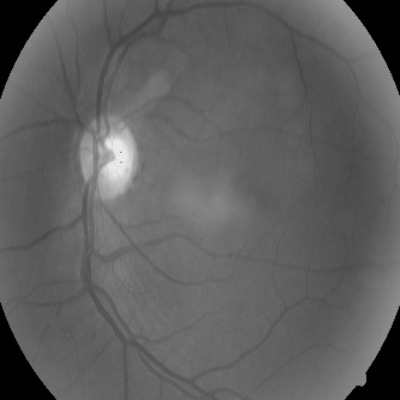

In [14]:
## CLAHE uygulamak için bize görüntümüzün siyah-beyaz kanallarda renk değerleri gerekiyor. Görüntümüz şuan BGR kanallarına sahip olduğundan, görüntü kanalları LAB döndürmemiz gerekiyor.
#LAB(Lightness=Parlaklık , A=Yeşil-Kırmızı , B= Mavi-Sarı renk katmanlarını içerir.)


lab=cv2.cvtColor(crop_son,cv2.COLOR_RGB2LAB)

lab.shape #gördüğünüz üzere bu 400'e 400 boyutlarında ve 3 katmanlı, bana sadece ilk kanal değerleri gerekiyor. Lightness kanalı..

#Lightness kanalını tek başına almam içinse cv2.split() fonksiyonunu kullanacağım.

l,a,b=cv2.split(lab) #görüntüyü ayırma.


cv2_imshow( l )
cv2.waitKey()
cv2.destroyAllWindows() 

Histogram Grafiği oluşturma ve yorumlama

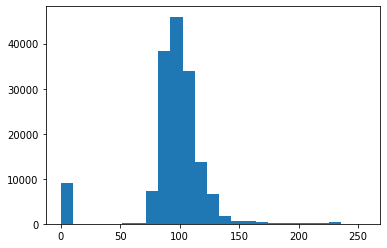

In [15]:
l.shape # tek kanallı (400, 400) görüntüm var. 

#Ben bunun histogram grafiğini oluşturmak istersem tek boyuta indirmem gerekir.

flattened=l.flatten() #Tek vektör haline getirme 

flattened.shape # (160000,) oldu.


####################### Grafiği çizme #########################
from matplotlib import pyplot as plt
plt.hist(flattened,25,[0,256]) #256 değerlere kadar gösterme
plt.show()

#Aşağıdaki resimde de görüldüğü gibi , bu resme normal histogram eşitleme yapıldığında yukarıda uyardığımız duruma geldik.(bir değerde pik yapma durumu.)


#Bu yüzden Kontrast Limitli Adaptif Histogram Eşitleme yapacağız.

######## Kontrast Limitli Adaptif Histogram Eşitleme ##########
# cv2.createCLAHE(Kontrast limiti , çerçeve boyutu) ardından clahe.apply(görüntü)

clahe=cv2.createCLAHE(clipLimit=7.0,tileGridSize=((8,8)))
#tileGridSize kısmı yazımızda yazdığımız gibi işin,adaptif kısmı; yani resmi 8'e 8'lik küçük karelere ayırarak işlemi adaptif şeklinde gerçekleştiriyor.
#clipLimit ise Kontrast Limit kısmını oluşturuyor. Verdiğimiz 7 değeri ise ayrılan 8'e 8'lik parçalarda, 7 üstünde bir kontrast değeri çıkması halinde bu değeri yandaki komşu parçalara ayırıyor.

cl=clahe.apply(l) #clahe.apply(görüntü)


Yapılan değişiklere bakma CHALE uygulanmış histogram görüntüsü 

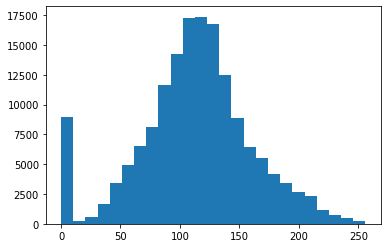

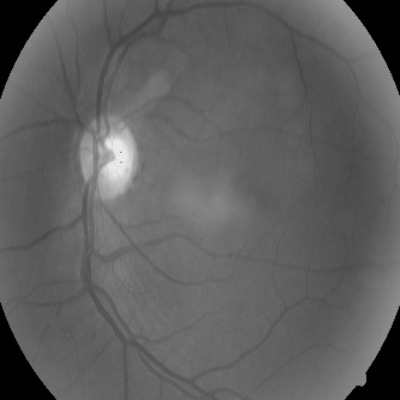

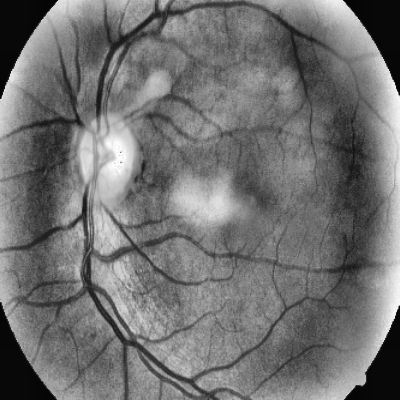

In [16]:
plt.hist(cl.flatten(),25,[0,256]) #256 değerlere kadar gösterme
plt.show()

#Artık pixel değerlerin birbirlerine daha yakın olduğunu yaptık. 

#işlemi uygulamadan önceki hali:
cv2_imshow( l )
cv2.waitKey()
cv2.destroyAllWindows() 


#Görüntüsüne bakmak gereqkirse:
cv2_imshow( cl )
cv2.waitKey()
cv2.destroyAllWindows() 


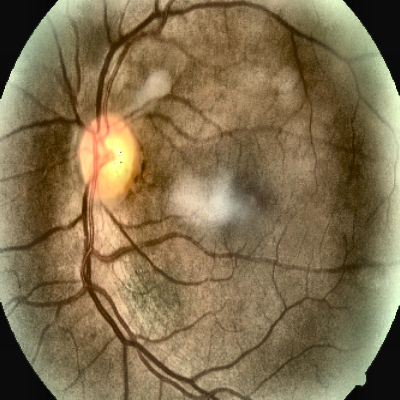

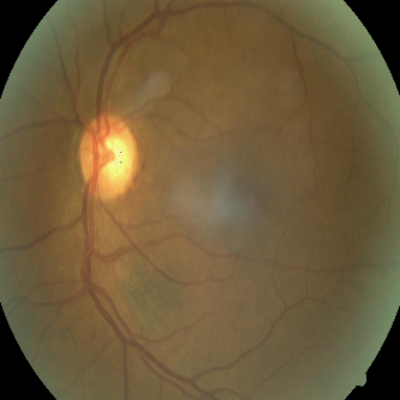

In [17]:
#Şimdi elde ettiğim parlak katmanını L-A-B kanalları ile birleştirip,tekrardan RGB kanallarına getireceğim.

limg=cv2.merge((cl,a,b))

#RGB dönüştürme

son_img=cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)

cv2_imshow( son_img )
cv2.waitKey()
cv2.destroyAllWindows() 



#İşlemleri yapmadan önceki görüntü 
cv2_imshow( crop_son )
cv2.waitKey()
cv2.destroyAllWindows() 

#Her ne kadar istemesek de görüntümüzde bazı kumlanmış yerleri farkediliyor. Bir sonraki satırda bununla ilgili işlemler yapacağız.



Median Blur


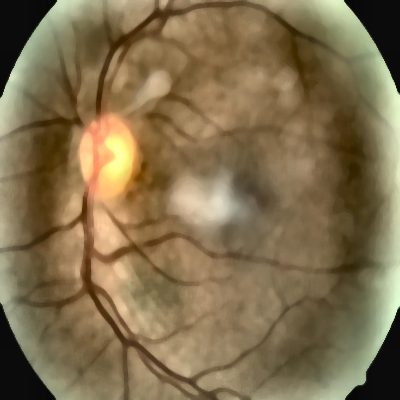

In [18]:
#Kumlanma - Biber-Karabiber(Noise) başa çıkmak için Median Blur kullanacağız.

med_son=cv2.medianBlur(son_img,7) #cv2.medianBlur(görüntü,kernel_boyutu(tek sayı)) olacaktır.

cv2_imshow( med_son )
cv2.waitKey()
cv2.destroyAllWindows() 


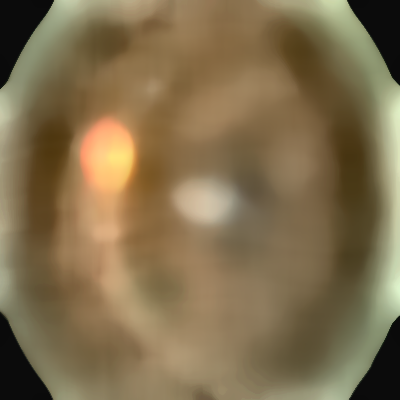

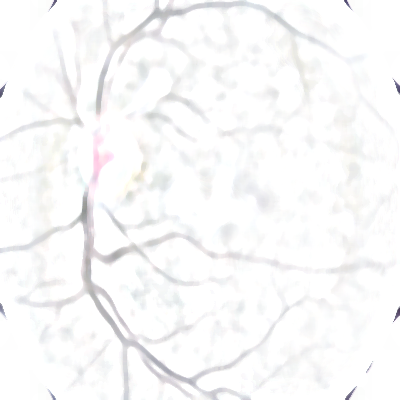

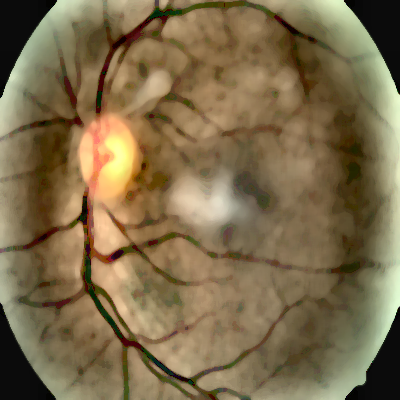

In [19]:
#Arka plan görüntüsü oluşturma. (Bunu ağır bir kernel_size kullanarak yapacağım)

mask=cv2.medianBlur(son_img,37)
cv2_imshow( mask )
cv2.waitKey()
cv2.destroyAllWindows() 


#Şimdi verideki ön işlemede son kısmına geçiyoruz.
#Modelimizin retina içerisindeki kanamaları daha iyi tespit edebilmesi için,kanamayı noktalarının belirgenleşmesi için bir maske'leme uygulayacağız.(addWeight(görüntü1,oran1,görüntü2,gamma) ağırlıklarla ekleme.)



maskeli_img= cv2.addWeighted(med_son,1,mask,-1,255)

#-1 demek görüntünün tersi demek yani ben blurlanmış görüntünün tersi ile birleştiriyorum damarların gözükmesi için.

cv2_imshow( maskeli_img )
cv2.waitKey()
cv2.destroyAllWindows() 

#bulduğumuz görüntü şuanlık bir işimize yaramıyor.OpenCv'deki bitwise operatörleri kullanacağız.
#bitwise_and methoduyla damarların daha belirgin olmasını sağlayacağız.
last_img=cv2.bitwise_and(maskeli_img,med_son)

cv2_imshow(last_img)
cv2.waitKey()
cv2.destroyAllWindows() 

Tüm kodları toplama

In [20]:
img_list= [] 

#kodun aşamasını görmek için taqqadum modülünü çalıştırabilirsiniz.taqqadum=== İLERLEME DEMEK

from tqdm import tqdm_notebook as tqdm

for i in tqdm(files): #ilk on görüntüyü alıcaz 35 görüntüyü almak biraz zorlaşacaktır.
    image=cv2.imread(path1 + "dataset/"+i) #dosyaların bulunduğu konumu girmemizi istiyoruz ardından okunan her görüntüyü temsil etmesi için "i" ekliyoruz.
    image=cv2.resize(image,(400,400)) #boyutlarını ayarlama.
    #boş listeye ekleme
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #Gri kanala çevir
    kopya=image.copy()
    kopya=cv2.cvtColor(kopya,cv2.COLOR_BGR2GRAY)
    #Blur'lama işlemi uygula.
    blur=cv2.GaussianBlur(kopya,(5,5),0)
    thresh=cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1] #threshold ikinci değişkeni lazım, ilk değişkeni threshold değerini verir.
    #contour'ları bulma
    contour=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] ##Retr_external sadece dış contourları çıkarmak istiyorsanız faydalı olabilir. Aykırı değerleri döndürürken, CHAIN_APPROX_SIMPLE ise sadece uçtaki 4 noktanın konumunu bize verir.
    contour=contour[0] # bu şekilde tuple'dan kurtuldum.
    contour=contour[:,0,:] #fazla boyuttan kurtulma
    #x1-x2-y1-y2 belirleme
    x1=tuple(contour[contour[:,0].argmin()])[0] #sol
    x2=tuple(contour[contour[:,0].argmax()])[0] #sag
    y1=tuple(contour[contour[:,1].argmin()])[1] #alt
    y2=tuple(contour[contour[:,1].argmax()])[1] #ust
    #karanlık yerlerden daha çok kurtulmak için
    x=int(x2-x1)*4//50
    y=int(y2-y1)*5 //50 #4-5 sayıları opsiyonel

    #Her zaman mükemmel şekilde görüntü contour almayabilir.bunun önüne geçmek için
    if x2-x1 > 100 and y2-y1>100:
        kopya2=image.copy()
        kopya2=kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2=cv2.resize(kopya2,(400,400))


    #L-A-B kanalları
    lab=cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b=cv2.split(lab) # l , a ,b kanallarının ayrılması
    #lazım olan l(lightness) kanalına Kontrast ayarlı ADAPTİF histogram eşitleme uygulanması
    clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=((7,7)))
    #tileGridSize kısmı yazımızda yazdığımız gibi işin,adaptif kısmı; yani resmi 8'e 8'lik küçük karelere ayırarak işlemi adaptif şeklinde gerçekleştiriyor.
    #clipLimit ise Kontrast Limit kısmını oluşturuyor. Verdiğimiz 7 değeri ise ayrılan 8'e 8'lik parçalarda, 7 üstünde bir kontrast değeri çıkması halinde bu değeri yandaki komşu parçalara ayırıyor.

    cl=clahe.apply(l) #clahe.apply(görüntü)

    #Şimdi elde ettiğim parlak katmanını L-A-B kanalları ile birleştirip,tekrardan RGB kanallarına getireceğim.

    limg=cv2.merge((cl,a,b))
    son_img=cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)

    #Kumlanma - Biber-Karabiber(Noise) başa çıkmak için Median Blur kullanacağız.

    med_son=cv2.medianBlur(son_img,7) #cv2.medianBlur(görüntü,kernel_boyutu(tek sayı)) olacaktır.
    
    #Arka plan görüntüsü oluşturma. (Bunu ağır bir kernel_size kullanarak yapacağım)

    mask=cv2.medianBlur(son_img,23)

    maskeli_img= cv2.addWeighted(med_son,1,mask,-1,255)

    #-1 demek görüntünün tersi demek yani ben blurlanmış görüntünün tersi ile birleştiriyorum damarların gözükmesi için.

    last_img=cv2.bitwise_and(maskeli_img,med_son)


    #tüm işlemler sonucunda listeye ekleme
    img_list.append(last_img)

<ipython-input-20-b024ed04863e>:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/1427 [00:00<?, ?it/s]

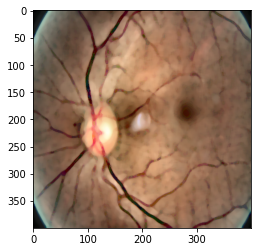

In [21]:
plt.imshow(img_list[5])

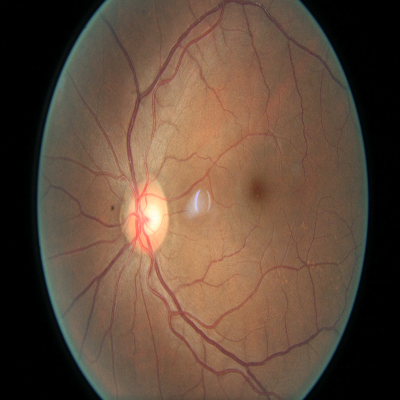

In [22]:
cv2_imshow(img_list1[5])
cv2.waitKey()

cv2.destroyAllWindows()

Sınıflar arasında önişleme işlemleri

Label'lara-OneHotEncoding işlemi

In [23]:
#histogram grafiğini gösterme

y_train=pd.get_dummies(data['level']).values

#bunu yapmamızın temel nedeni şu, modelimizi tasarlarken çıkış nöronuna sınıf sayımız kadar noron koyacağız,ancak 4. sınıfımız olabilmesi için--> ilk durumları da içerisinde bulundurması gerektiğini belirtmiştik.
y_train

#Bundan dolayı, bazı işlemler yapmak zorundayız.


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [24]:
import numpy as np
y_train_son=np.ones(y_train.shape,dtype="uint8")
#4 durumda olabilmesi için diğer sınıfları da bulunan özellikleri de bulundurması gerekiyor.

y_train_son[:,4]=y_train[:,4]


for i in range(3,-1,-1): #3'ten geriye 1'er saymasını istiyoruz.
    y_train_son[:,i]=np.logical_or(y_train[:,i],y_train_son[:,i+1])#burada #4 sınıfta olması için tüm özellikleri barındırması gerektiğini söylemiştik. Ve bunun için logical_and'leme işlemi kullanarak, etiketleri istediğimiz şekle getirdik.

y_train_son 
#şayet böyle yapmasaydık, 1 derecedeki ile 4 derecedeki farklıymış gibi algılayacaktır. Ancak bunların birbiriyle bağlantıları var.
#yani bilgisayar artık 2 derecede bulduğu bir görüntüyü gelirken, 1'dereceden farklı olarak farklı şeyler bulduğu için sınıflandırma yapcaktır.

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

TEST VE TRAIN OLARAK AYRILMASI

In [25]:
x_train=np.array(img_list) #array formatına çeviriyoruz.

#ikisinde aynı boyutta olmalı
x_train.shape,y_train_son.shape

((1427, 400, 400, 3), (1427, 5))

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train_son, test_size=0.15, random_state=42,shuffle=True)



In [27]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1212, 400, 400, 3), (215, 400, 400, 3), (1212, 5), (215, 5))

In [28]:
#Test ve Train olarak ayırdıktan sonra bir sonraki adım ise Görüntülerimizi (keras kütüphanesi yardımıyla) tensör haline getirmek.

from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(horizontal_flip=True,vertical_flip=True) #Data Augmentaion
data_generator=datagen.flow(X_train,y_train,batch_size=6,seed=2020) #.flow() methodu=görüntüleri ve sınıflandırma verilerini alır,modele eğitime girmeye hazır tensörler oluşturur.


In [29]:
!pip install efficientnet
from efficientnet.keras import EfficientNetB1

# ornek_model = EfficientNetB5()

# ornek_model.summary() #son üç katmanı donduracağız. Çünkü sınıflandırdığımız output çıkışı farklı

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# ornek_model2=EfficientNetB5(include_top=False)

#Son yoğun katmanları isteyip istemediğimizi seçmememizi sağlar.
#İstediğimizde True , istemediğimizde False işaretleriz


#Şimdi kendi çıkış katmanlarımızı eklememiz gerekiyor.
from keras.models import Sequential
from keras import layers


model=Sequential () 
model.add(EfficientNetB1(weights="imagenet",include_top=False,input_shape=(400,400,3))) #biz transfer learning'in oluşturduğu feature map() yüksek olmayan  ) kullanıp daha başarılı sonuçlar elde etmek istiyoruz.
#ağırlıklar olarak imagenet kullanıp, input_shape ise resimlerin boyutlarını giriyorum

#Son katmanları çıkardık, şimdi son katmanları kendimizce ekleme zamanı:
NUM_OF_CLASS=5

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(NUM_OF_CLASS,activation="sigmoid"))


27164032/27164032 [==============================] - 0s 0us/step



Modeli Derleme


In [32]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=.0005),loss="binary_crossentropy",metrics=["accuracy"])

#sigmoid kullandığımız için loss fıunction olarak categorical_crossentropy yerine , binary _crossentropy kullanacağız. Çoğu yazılımcı
#sigmoid--> binary
#softmax--> categorical kullanır


#şimdi modelimizi eğitirken learning_rate nasıl otomatik olaarak nasıl artırıp azaltacağız ona bakalım.




In [33]:
#şimdi modelimizi eğitirken learning_rate nasıl otomatik olaarak nasıl artırıp azaltacağız ona bakalım.
from keras.callbacks import ReduceLROnPlateau

lr=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.25,min_lr=0.000001)
#monitor(izlenen yer), neyi baz alacağı
#patience gösterilen sabır
#verbose ve mode önemli değil

#factor,hep aynı sonucu veren learning rate ile çarpılma sonucu
#min_lr= gidilecek en küçük öğrenme oranını temsil eder.

  

In [34]:
#Eğitim aşaması 


history=model.fit(data_generator,
                            steps_per_epoch=50,
                            epochs=3,
                            validation_data=(X_test,y_test),callbacks=[lr],verbose=1)



Epoch 1/3
50/50 [==============================] - 52s 383ms/step - loss: 0.3782 - accuracy: 0.9433 - val_loss: 0.3633 - val_accuracy: 0.9953 - lr: 5.0000e-04
Epoch 2/3
50/50 [==============================] - 13s 261ms/step - loss: 0.2891 - accuracy: 1.0000 - val_loss: 0.3993 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 3/3
50/50 [==============================] - 14s 291ms/step - loss: 0.2617 - accuracy: 1.0000 - val_loss: 0.3233 - val_accuracy: 1.0000 - lr: 5.0000e-04
